In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%cd /content/drive/MyDrive/Colab Notebooks/MLeng/07IBM Deep Learning/Project2

/content/drive/MyDrive/Colab Notebooks/MLeng/07IBM Deep Learning/Project2


In [ ]:
#!pip install tensorflow_cpu==2.18.0

In [ ]:
#Univariate and Multivariate time series forecasting of pressure sensors in particle accelerators using RNN, LSTM, and Transformer models
'''
Context and Problem Statement:
- A particle accelerator is a large machine which accelerates particles (such as electron, protron) and produces synchrotron radiation (such as X-ray, Infrared, Ultraviolet). The radiation can be used for a wide range of research in materials science, chemistry and medicine.
- The high quality of particles and the synchrotron radiation produced from the accelerator require stable vacuum systems. These vacuum systems rely on several pressure sensors placed around the accelerator to provide real-time pressure levels in different sections.
- Unforeseen pressure fluctuations, if not detected and addressed promptly, can lead to significant disruptions of the accelerator and potential damage of sensitive instruments.
- In order to early detect and accurately predict the pressure change, deep learning techniques including Recurrent Neural Networks (RNNs), Long Short-Term Memory (LSTM) networks, and Transformer models have been applied.
- This project also aims to investigate the effectiveness of different deep learning architectures for predicting univariate and multivariate time series data from pressure sensors by comparing the performance, evaluation, and forecasting of these models.
- Multivariate time series forecasting: The pressure value of a pressure sensor is dependent not only on its previous values but also on the pressure values of other sensors in the accelerator. Thus, the pressure values from all sensors should be considered to forecast the future pressure values.
- Hyperparameter tuning with BayesianOptimization using Gaussian process was performed for finding optimal number of neurons in hidden layers and optimal dropout rate in dropout layers.
- Regularization techniques consisting of dropout layer, batch normalization layer, and early stopping were used to address overfitting in the neural network.
- Custom callbacks of monitoring validation loss, early stopping, and learning rate scheduling were determined for improving model performance.


Process: 1. Data import
         2. Data wrangling >>> select data points and features, pearson correlation
         3. Data preprocessing for univariate time series >>> MinMaxScaler, split data, create sequential data
         4. Data preprocessing for multivariate time series >>> MinMaxScaler, split data, create sequential data
         5. Custom callbacks >>> Monitoring validation loss, Early stopping, and Learning rate scheduling
         6. RNN model with hyperparameter tuning
         7. LSTM model with hyperparameter tuning
         8. Transformer model with hyperparameter tuning >>> Multi-head self-attention layer, Feed-forward neural network layer, Residual Connection, and Layer Normalization
         9. Model training and hyperparameter tuning
            9.1 Create a Keras Tuner >>> BayesianOptimization/Hyperband/RandomSearch
            9.2 Train model with hyperparameter search
            9.3 Train model again with best hyperparameters
            9.4 Plot model performance
            9.5 Predict model and plot prediction
            9.6 Evaluate model
            9.7 Save model, history, prediction, evaluation, and best hyper tuning
         10. RNN with univariate times series
         11. LSTM with univariate times series
         12. Transformer with univariate times series
         13. RNN with multivariate times series
         14. LSTM with multivariate times series
         15. Transformer with multivariate times series
         16. Visualization of validation performance with accuracy and loss curves
         17. Model evaluation for all approaches
         18. Visualization of model predictions for all approaches
         19. Time series forecasting for all approaches

'''

In [ ]:
!pip install keras-tuner==1.4.7

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import tensorflow as tf
import keras
import requests
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.layers import Layer, Dense, LayerNormalization, Dropout, Flatten, BatchNormalization, SimpleRNN, LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, LearningRateScheduler
from tensorflow.keras.optimizers import Adam
import keras_tuner as kt
import os
import warnings
import sys
import time

sys.setrecursionlimit(100000)                      # prevent potential recursion errors when running complex models with deep nested functions or when using certain libraries like TensorFlow.
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'           # Set TensorFlow log level to suppress warnings and info messages >>> 0 = all logs, 1 = filter out INFO, 2 = filter out INFO and WARNING, 3 = ERROR only

In [ ]:
#1. Data import
file_name="Project2_sensor.csv"
df = pd.read_csv(file_name)       #header=0 >>> load using first row as header
print(df.head(5))

             timestamp  aimp  amud       arnd    asin1   asin2  adbr  adfl  \
0  2023-01-01 00:00:00   0.0   1.0  20.000000  0.00000  0.0000   0.0   0.0   
1  2023-01-01 00:00:01   0.0   1.0  20.080031  0.00002  0.0002   0.0   0.0   
2  2023-01-01 00:00:02   0.0   1.0  20.276562  0.00004  0.0004   0.0   0.0   
3  2023-01-01 00:00:03   0.0   1.0  20.730938  0.00006  0.0006   0.0   0.0   
4  2023-01-01 00:00:04   0.0   1.0  21.118101  0.00008  0.0008   0.0   0.0   

   bed1  bed2  bfo1          bfo2      bso1  bso2  bso3  ced1      cfo1  \
0   0.0   0.0   0.0  0.000000e+00  0.000000   0.0   0.0   0.0  0.000000   
1   0.0   0.0   0.0  4.993912e-07  0.000789   0.0   0.0   0.0  0.000021   
2   0.0   0.0   0.0  1.496957e-06  0.003115   0.0   0.0   0.0  0.000104   
3   0.0   0.0   0.0  2.991484e-06  0.006914   0.0   0.0   0.0  0.000285   
4   0.0   0.0   0.0  4.981761e-06  0.012123   0.0   0.0   0.0  0.000601   

       cso1  
0  0.000000  
1  0.001229  
2  0.004833  
3  0.010688  
4  0.01866

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 19 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   index      150000 non-null  int64  
 1   timestamp  150000 non-null  object 
 2   aimp       150000 non-null  float64
 3   amud       150000 non-null  float64
 4   arnd       150000 non-null  float64
 5   asin1      150000 non-null  float64
 6   asin2      150000 non-null  float64
 7   adbr       150000 non-null  float64
 8   adfl       150000 non-null  float64
 9   bed1       150000 non-null  float64
 10  bed2       150000 non-null  float64
 11  bfo1       150000 non-null  float64
 12  bfo2       150000 non-null  float64
 13  bso1       150000 non-null  float64
 14  bso2       150000 non-null  float64
 15  bso3       150000 non-null  float64
 16  ced1       150000 non-null  float64
 17  cfo1       150000 non-null  float64
 18  cso1       150000 non-null  float64
dtypes: float64(17), int64(1

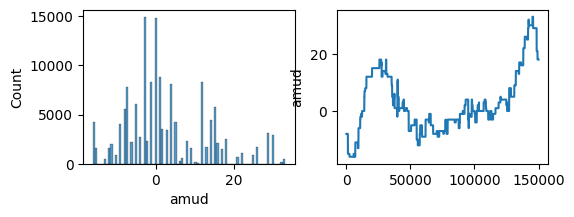

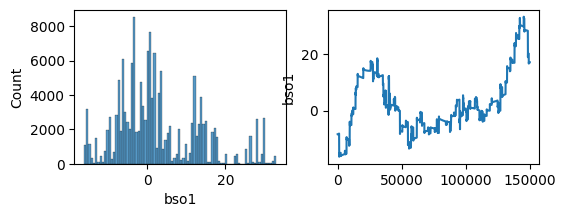

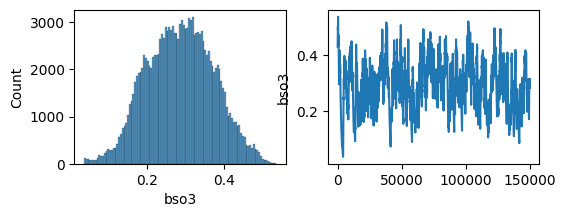

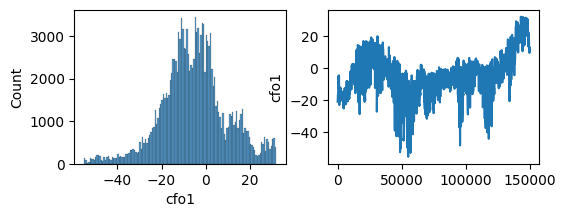

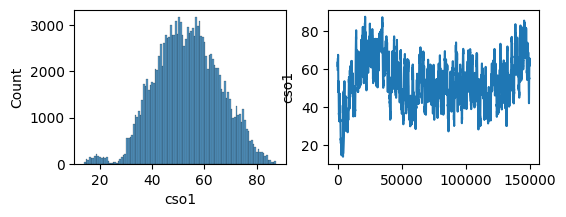

   amud      bso1      bso3       cfo1       cso1
0  -8.0 -8.267045  0.429464 -20.978125  59.697235
1  -8.0 -8.266853  0.430066 -20.963570  59.764414
2  -8.0 -8.266660  0.430668 -20.948837  59.832822
3  -8.0 -8.266467  0.431268 -20.933950  59.902225
4  -8.0 -8.266274  0.431868 -20.918999  59.972401
                amud           bso1           bso3           cfo1  \
count  150000.000000  150000.000000  150000.000000  150000.000000   
mean        2.724427       2.756146       0.286904      -5.151159   
std        10.654732      10.569546       0.086723      14.896035   
min       -16.000000     -16.166674       0.036178     -55.194082   
25%        -4.000000      -4.133426       0.223666     -13.920037   
50%         0.000000       0.671129       0.287962      -5.165802   
75%        11.000000      11.147846       0.348863       2.796134   
max        33.000000      32.998351       0.536752      31.984687   

                cso1  
count  150000.000000  
mean       53.596041  
std      

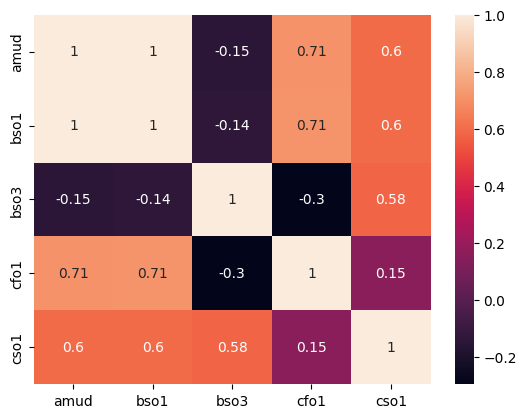

In [ ]:
#2. Data wrangling >>> select data points and features, pearson correlation
df1=df.iloc[3800000:3950000].reset_index()                  # reduce data from 5millions to 150000
print(df1.info())
col=['amud','bso1','bso3','cfo1','cso1']                    # select corresponding columns/features
for i in range(len(col)):
  x=col[i]
  fig, axs = plt.subplots(ncols=2, figsize=(6, 2))
  plt.rcParams['font.size'] = '10'
  sns.histplot(df1[x],ax=axs[0])
  plt.plot(df1[x])
  plt.ylabel(x)
  plt.show()

df2=df1[col]
print(df2.head())
print(df2.describe(include="all"))

# Pearson correlation >>> +1=Perfect positive linear correlation, -1=Perfect negative linear correlation, 0=No linear correlation
plt.subplot()
sns.heatmap(df2.corr(), annot=True)
plt.show()

Shape of x train: (104899, 100, 1)
Shape of y train: (104899,)


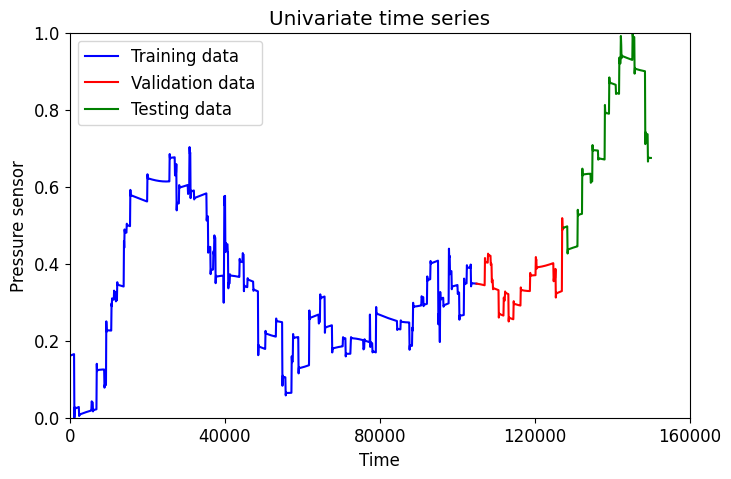

In [ ]:
#3. Data preprocessing for univariate time series >>> MinMaxScaler, split data, create sequential data
df2_uni = df2['bso1']
df2_uni = np.reshape(df2_uni, (-1, 1))                # MinMaxScaler expects a 2-dimensional input
# Normalization
scalerUni = MinMaxScaler(feature_range=(0,1))
df2_uni_norm = scalerUni.fit_transform(df2_uni)

# Split data to training, testing, validating set
num_train = int(len(df2_uni_norm)*(70/100))                     # train data = 70%
num_val = int(len(df2_uni_norm)*(15/100))                       # val data = 15%, test data = 15%
train_uni = df2_uni_norm[:num_train]
val_uni = df2_uni_norm[num_train:(num_train+num_val)]
test_uni = df2_uni_norm[(num_train+num_val):]

# Create sequential data
def create_dataset(data, time_step=1):
    X, Y = [], []
    for i in range(len(data)-time_step-1):
        X.append(data[i:(i+time_step), 0])                  # X[i] = each sequence will contain a specific number of time series
        Y.append(data[i + time_step, 0])                    # Y[i] = target variable will be the next value in the series
    return np.array(X), np.array(Y)

time_step = 100
x_train_uni, y_train_uni = create_dataset(train_uni, time_step)
x_val_uni, y_val_uni = create_dataset(val_uni, time_step)
x_test_uni, y_test_uni = create_dataset(test_uni, time_step)

x_train_uni = x_train_uni.reshape(x_train_uni.shape[0], x_train_uni.shape[1] , 1)       # reshape x data to fit LSTM input shape requirement [batch size, number of time step, number of feature]
x_val_uni = x_val_uni.reshape(x_val_uni.shape[0], x_val_uni.shape[1] , 1)
x_test_uni = x_test_uni.reshape(x_test_uni.shape[0], x_test_uni.shape[1] , 1)
print("Shape of x train:", x_train_uni.shape)
print("Shape of y train:", y_train_uni.shape)

# Visualize data
plt.figure(figsize = (8,5))
plt.rcParams['font.size'] = '12'
plt.plot(range(num_train),train_uni, color = 'b', label = 'Training data')
plt.plot(range(num_train,num_train+num_val),val_uni, color = 'r', label = 'Validation data')
plt.plot(range(num_train+num_val,num_train+num_val+len(test_uni)),test_uni, color = 'g', label = 'Testing data')
plt.title('Univariate time series')
plt.xlabel('Time')
plt.ylabel('Pressure sensor')
plt.xlim(0,160000)
plt.xticks(np.arange(0,200000,40000))
plt.ylim(0,1)
plt.legend()
plt.show()

Shape of x train: (104899, 100, 5)
Shape of y train: (104899,)


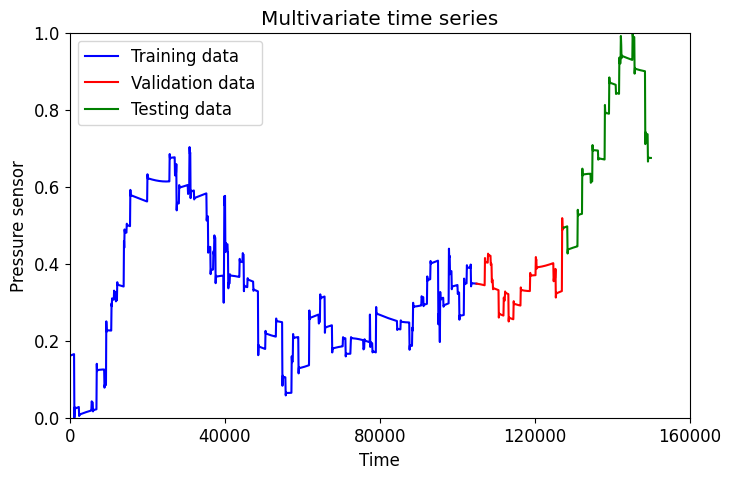

In [ ]:
#4. Data preprocessing for multivariate time series >>> MinMaxScaler, split data, create sequential data
# Normalization
scalerMulti = MinMaxScaler(feature_range=(0,1))
df2_norm = scalerMulti.fit_transform(df2)

# Split data to training, testing, validating set
num_train = int(len(df2_norm)*(70/100))                     # train data = 70%
num_val = int(len(df2_norm)*(15/100))                       # val data = 15%, test data = 15%
train_multi = df2_norm[:num_train]
val_multi = df2_norm[num_train:(num_train+num_val)]
test_multi = df2_norm[(num_train+num_val):]

# Create sequential data
def create_dataset(data, time_step=1):
    X, Y = [], []
    for i in range(len(data)-time_step-1):
        X.append(data[i:(i+time_step), :])                  # X[i] = each sequence will contain a specific number of time series
        Y.append(data[i + time_step, 1])                    # choose second column(1) for Y[i] = target variable will be the next value in the series
    return np.array(X), np.array(Y)

time_step = 100
x_train_multi, y_train_multi = create_dataset(train_multi, time_step)
x_val_multi, y_val_multi = create_dataset(val_multi, time_step)
x_test_multi, y_test_multi = create_dataset(test_multi, time_step)
print("Shape of x train:", x_train_multi.shape)
print("Shape of y train:", y_train_multi.shape)

# Visualize data
plt.figure(figsize = (8,5))
plt.rcParams['font.size'] = '12'
plt.plot(range(num_train),train_multi[:,1], color = 'b', label = 'Training data')
plt.plot(range(num_train,num_train+num_val),val_multi[:,1], color = 'r', label = 'Validation data')
plt.plot(range(num_train+num_val,num_train+num_val+len(test_multi[:,1])),test_multi[:,1], color = 'g', label = 'Testing data')
plt.title('Multivariate time series')
plt.xlabel('Time')
plt.ylabel('Pressure sensor')
plt.xlim(0,160000)
plt.xticks(np.arange(0,200000,40000))
plt.ylim(0,1)
plt.legend()
plt.show()

In [ ]:
#5. Custom callbacks >>> Monitoring validation loss, Early stopping, and Learning rate scheduling
class LossHistory_(tf.keras.callbacks.Callback):     # monitoring the validation loss
    def on_train_begin(self, logs={}):
        self.losses = []
        self.lr = []
    def on_epoch_end(self, epoch, logs={}):
        self.losses.append(logs.get('loss'))
        self.lr.append(exp_decay(epoch))
        print(' - lr:', exp_decay(len(self.losses)))

def exp_decay(epoch):                                # Define a learning rate scheduler >>> that reduces the learning rate exponentially
    initial_lrate = 1e-4
    k = 0.1
    lrate = initial_lrate * np.exp(-k*epoch)
    return lrate

loss_history_ = LossHistory_()                       # monitoring the validation loss
early_stopping = EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True, mode = 'min', min_delta=0.00001)             # Stops training when loss no longer improves, preventing overfitting. >>> 3=Will stop training if the "val_loss" hasn't improved in 3 epochs.
lr_scheduler = LearningRateScheduler(exp_decay)                                                                                 # Define a learning rate scheduler
#lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=1e-6, verbose=1)                           # Reduces learning rate when validation loss plateaus, allowing better optimization.

callbacks_list_ = [loss_history_, lr_scheduler, early_stopping]

In [ ]:
#6. RNN model with hyperparameter tuning
def RNN_model(hp):                                      # Define layers and tuning hyperparameters
    model = Sequential([
        SimpleRNN(units=hp.Int('units', min_value=64, max_value=128, step=32), activation='relu', return_sequences=True, input_shape=InputShape),               # Hyperparameter1: number of units in the hidden layer
        SimpleRNN(units=hp.Int('units', min_value=64, max_value=128, step=32), activation='relu', return_sequences=True),                                       # Hyperparameter1: number of units in the hidden layer
        SimpleRNN(units=hp.Int('units', min_value=64, max_value=128, step=32), activation='relu'),                                                              # Hyperparameter1: number of units in the hidden layer
        Dropout(hp.Float('dropout', min_value=0.0, max_value=0.4, step=0.2)),                                                                                   # Hyperparameter2: dropout rate
        BatchNormalization(),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])
    print(model.summary())
    return model


In [ ]:
#7. LSTM model with hyperparameter tuning
def LSTM_model(hp):                                      # Define layers and tuning hyperparameters
    model = Sequential([
        LSTM(units=hp.Int('units', min_value=64, max_value=128, step=32), activation='relu', return_sequences=True, input_shape=InputShape),               # Hyperparameter1: number of units in the hidden layer
        LSTM(units=hp.Int('units', min_value=64, max_value=128, step=32), activation='relu', return_sequences=True),                                       # Hyperparameter1: number of units in the hidden layer
        LSTM(units=hp.Int('units', min_value=64, max_value=128, step=32), activation='relu'),                                                              # Hyperparameter1: number of units in the hidden layer
        Dropout(hp.Float('dropout', min_value=0.0, max_value=0.4, step=0.2)),                                                                                   # Hyperparameter2: dropout rate
        BatchNormalization(),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])
    print(model.summary())
    return model

In [ ]:
#8. Transformer model with hyperparameter tuning

#  defines the multi-head self-attention mechanism >>> allows the model to focus on different parts of the input sequence simultaneously >>> parallel attention computation
class MultiHeadSelfAttention(Layer):
    def __init__(self, embed_dim, num_heads=8):                   # initializes the dense layers for query, key and value projections
        super(MultiHeadSelfAttention, self).__init__()
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.projection_dim = embed_dim // num_heads
        self.query_dense = Dense(embed_dim)                       # Linear transformations of the queries
        self.key_dense = Dense(embed_dim)                         # Linear transformations of the key
        self.value_dense = Dense(embed_dim)                       # Linear transformations of the value
        self.combine_heads = Dense(embed_dim)

    def attention(self, query, key, value):                        # computes the attention weight and output from Query, Key, Value
        score = tf.matmul(query, key, transpose_b=True)            # computes the attention scores = dot product of Query and Key vectors
        dim_key = tf.cast(tf.shape(key)[-1], tf.float32)
        scaled_score = score / tf.math.sqrt(dim_key)
        weights = tf.nn.softmax(scaled_score, axis=-1)             # use Softmax function to normalize the attention scores to probabilities and get the attention weight
        output = tf.matmul(weights, value)                         # dot product of the attention weight and Value vectors to get the output
        return output, weights

    def split_heads(self, x, batch_size):                          # splits the input tensor into multiple heads for parallel attention computation
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.projection_dim))   # The resulting tensor will have shape (batch_size, num_heads, seq_len, depth).
        return tf.transpose(x, perm=[0, 2, 1, 3])

    def call(self, inputs):                                        # applies the self-attention mechanism and combines the heads
        batch_size = tf.shape(inputs)[0]
        query = self.query_dense(inputs)
        key = self.key_dense(inputs)
        value = self.value_dense(inputs)
        query = self.split_heads(query, batch_size)                 # split query vector into heads
        key = self.split_heads(key, batch_size)                     # split key vector into heads
        value = self.split_heads(value, batch_size)                 # split value vector into heads
        attention, _ = self.attention(query, key, value)
        attention = tf.transpose(attention, perm=[0, 2, 1, 3])
        concat_attention = tf.reshape(attention, (batch_size, -1, self.embed_dim))
        output = self.combine_heads(concat_attention)
        return output                                             # output of self-attention layer

# define the Transformer layers >>> combines multi-head self-attention with a feed-forward neural network, normalization layers, dropout layers
class TransformerBlock(Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):       # initializes layers
        super(TransformerBlock, self).__init__()
        self.att = MultiHeadSelfAttention(embed_dim, num_heads)       # self-attention layer for custom class, or 'self.att = tf.keras.layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)'
        self.ffn = tf.keras.Sequential([                              # feedforward neural network layers
            Dense(ff_dim, activation="relu"),                         # Dense layer adds nonlinearlity to the model through Activation function
            Dense(embed_dim),
        ])
        self.layernorm1 = LayerNormalization(epsilon=1e-6)
        self.layernorm2 = LayerNormalization(epsilon=1e-6)
        self.dropout1 = Dropout(rate)                                  # Dropout to prevent overfitting
        self.dropout2 = Dropout(rate)

    def call(self, inputs, training):                                  # applies the self-attention followed by the feed-forward network with residual connections, normalization layers and dropout layers
        attn_output = self.att(inputs)                                 # self.att(inputs, inputs, inputs, attention_mask=mask)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

# defines the transformer encoder >>> composed of multiple TransformerBlock layers to implement the encoding part of the Transformer architecture
class TransformerEncoder(Layer):
    def __init__(self, num_layers, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerEncoder, self).__init__()
        self.num_layers = num_layers
        self.embed_dim = embed_dim
        self.enc_layers = [TransformerBlock(embed_dim, num_heads, ff_dim, rate) for _ in range(num_layers)]
        self.dropout = Dropout(rate)

    def call(self, inputs, training=False):
        x = inputs
        for i in range(self.num_layers):
            x = self.enc_layers[i](x, training=training)
        return x

def Transformer_model(hp):                                      # Define layers and tuning hyperparameters
    global embed_dim, num_heads, ff_dim, num_layers
    embed_dim = hp.Int('units', min_value=64, max_value=128, step=32)           # Embedding size, Dense(embed_dim), embed_dim = dimensionality of the output space
    num_heads = 8             # Number of attention heads >>> splits the input into multiple heads for parallel attention computation
    ff_dim = 512              # Hidden layer size in feed forward network inside transformer
    num_layers = 4            # number of encoder layers, number of the Transformer layers (TransformerBlock)
    transformer_encoder = TransformerEncoder(num_layers, embed_dim, num_heads, ff_dim)       # Define the Transformer Encoder

    inputs = tf.keras.Input(shape=InputShape)                  # Input layer
    x = tf.keras.layers.Dense(units=embed_dim)(inputs)         # Embeding layer >>> convert input sequences into dense vectors >>> Project the inputs to the embed_dim
    encoder_outputs = transformer_encoder(x)                   # Encoder layer >>> include multiple tramsformer blocks (multi-head self-attention layer and a feed forward neural network layer)
    flatten = tf.keras.layers.Flatten()(encoder_outputs)       # flatten to 1D array
    dropout = Dropout(hp.Float('dropout', min_value=0.0, max_value=0.4, step=0.2))(flatten)                            # dropout layer
    outputs = tf.keras.layers.Dense(1)(flatten)                # output layer >>> final dense layer to predict the next value in the series

    model = tf.keras.Model(inputs, outputs)                    # Build the model
    model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])
    print(model.summary())
    return model


In [ ]:
#9. Model training and hyperparameter tuning
def train_tune_model (epoch_tuning, max_tuning, epoch, BatchSize, model, filename, plotname, scaler, df2_raw, x_train, y_train, x_val, y_val, x_test, y_test):
  global InputShape
  InputShape = (x_train.shape[1], x_train.shape[2])           # input shape for first layer

  # Create a Keras Tuner >>> BayesianOptimization/Hyperband/RandomSearch
  tuner = kt.BayesianOptimization(
      model,
      objective='val_accuracy',                         # metric to optimize >>> tuner will evaluate different hyperparameter combinations and find the best one based on validation accuracy.
      max_trials=max_tuning,                            # maximum number of different hyperparameter configurations to try
      executions_per_trial=2,                           # number of times to run each configuration
      #directory='Project2',                            # Specify the directory where these JSON files will be stored for easier retrieval and analysis of tuning results.
      project_name=filename
  )
  tuner.search_space_summary()                          # Display a summary of the search space

  # Train model with hyperparameter search
  tuner.search(x_train, y_train, epochs=epoch_tuning, validation_data=(x_val, y_val), batch_size=BatchSize, callbacks=callbacks_list_)        # using the search method of the tuner for running, validation data to evaluate the model's performance during the search
  #tuner.results_summary()                                                              # Display a summary of the results
  best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]                           # retrieve the best hyperparameter values
  print(f"""

  The optimal hyperparameter 1 is {best_hps.get('units')}.

  The optimal hyperparameter 2 is {best_hps.get('dropout')}.

  """)

  # Train model again with best hyperparameters
  model_best = tuner.hypermodel.build(best_hps)
  history_model_best = model_best.fit(x_train, y_train, epochs=epoch, validation_data=(x_val, y_val), batch_size=BatchSize, callbacks=callbacks_list_)

  # Plot model performance
  fig, ax1 = plt.subplots(figsize=(7, 5))
  plt.rcParams['font.size'] = '14'
  plt.title(plotname+' performance')
  ax2 = ax1.twinx()
  ax1.plot(history_model_best.history['accuracy'], color='g')
  ax1.set_xlabel('Epochs')
  ax1.set_ylabel('Accuracy', color='g')
  ax1.tick_params(axis="y", labelcolor='g')
  ax1.grid(False)

  ax2.plot(history_model_best.history['loss'], color='m')
  ax2.set_xlabel('Epochs')
  ax2.set_ylabel('Loss', color='m')
  ax2.tick_params(axis="y", labelcolor='m')
  ax2.grid(False)
  plt.show()

  # Predict model
  if scaler == scalerUni:
    predictions = model_best.predict(x_test)
    y_pred = scaler.inverse_transform(predictions)
  else:
    predictions = model_best.predict(x_test)
    predictions_expanded = np.repeat(predictions,x_test.shape[2], axis=-1)      # While scaling the data we had 5 column for each row, right now we are having only 1 column which is the target column.
    y_pred = scaler.inverse_transform(np.reshape(predictions_expanded,(len(predictions),x_test.shape[2])))[:,1]     # [:,1] = target variable = second column

  # Plot prediction
  plt.figure(figsize = (8,5))
  plt.plot(df2_raw, color = 'b', label='Actual data')
  plt.plot(np.arange(len(df2_raw)-len(y_pred), len(df2_raw)), y_pred, color = 'r', label='Prediction')
  plt.title(plotname+' times series')
  plt.xlabel('Time')
  plt.ylabel('Pressure sensor')
  plt.xlim(0,160000)
  plt.xticks(np.arange(0,200000,40000))
  plt.ylim(-20,40)
  plt.legend(prop={'size': 11})
  plt.show()

  # Evaluate model
  model_loss, model_acc = model_best.evaluate(x_test, y_test)
  print(f'Accuracy: {model_acc * 100:.2f}%')
  print(f'Loss: {model_loss:.4f}')

  # Save model, history, prediction, evaluation, and best hyper tuning
  model_best.save(filename+'.keras')                                      # save model after training
  if model == Transformer_model:                                            # save history
    his = np.empty(2, object)
    his[0] = history_model_best.history['accuracy']
    his[1] = history_model_best.history['loss']
    np.save(filename+'_history.npy', his)
  else:
    np.save(filename+'_history.npy', np.array(history_model_best))          # save history
  arr = np.empty(4, object)                                               # save prediction, evaluation, best hyper tuning
  arr[0] = y_pred
  arr[1] = model_acc
  arr[2] = model_loss
  arr[3] = best_hps
  np.save(filename+'_pred_eval.npy', arr)

Reloading Tuner from ./RNN_uni/tuner0.json
Search space summary
Default search space size: 2
units (Int)
{'default': None, 'conditions': [], 'min_value': 64, 'max_value': 128, 'step': 32, 'sampling': 'linear'}
dropout (Float)
{'default': 0.0, 'conditions': [], 'min_value': 0.0, 'max_value': 0.4, 'step': 0.2, 'sampling': 'linear'}


  The optimal hyperparameter 1 is 128.

  The optimal hyperparameter 2 is 0.0.

  


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn (SimpleRNN)          │ (None, 100, 128)       │        16,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_1 (SimpleRNN)        │ (None, 100, 128)       │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_2 (SimpleRNN)        │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 83,073 (324.50 KB)

 Trainable params: 82,817 (323.50 KB)

 Non-trainable params: 256 (1.00 KB)

None
Epoch 1/40
3279/3279 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - accuracy: 1.1114e-06 - loss: 0.0212 - lr: 9.048374180359596e-05
3279/3279 ━━━━━━━━━━━━━━━━━━━━ 402s 121ms/step - accuracy: 1.1140e-06 - loss: 0.0212 - val_accuracy: 0.0000e+00 - val_loss: 2.8909e-07 - learning_rate: 1.0000e-04
Epoch 2/40
3279/3279 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - accuracy: 1.2255e-05 - loss: 8.8252e-04 - lr: 8.187307530779819e-05
3279/3279 ━━━━━━━━━━━━━━━━━━━━ 419s 114ms/step - accuracy: 1.2254e-05 - loss: 8.8252e-04 - val_accuracy: 0.0000e+00 - val_loss: 0.0016 - learning_rate: 9.0484e-05
Epoch 3/40
3279/3279 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - accuracy: 1.1147e-06 - loss: 9.3313e-04 - lr: 7.408182206817179e-05
3279/3279 ━━━━━━━━━━━━━━━━━━━━ 383s 115ms/step - accuracy: 1.1173e-06 - loss: 9.3313e-04 - val_accuracy: 0.0000e+00 - val_loss: 2.8023e-04 - learning_rate: 8.1873e-05
Epoch 4/40
3279/3279 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - accuracy: 5.5692e-05 - loss: 9.9683e-04 - lr: 6.703200460356394e-05
32

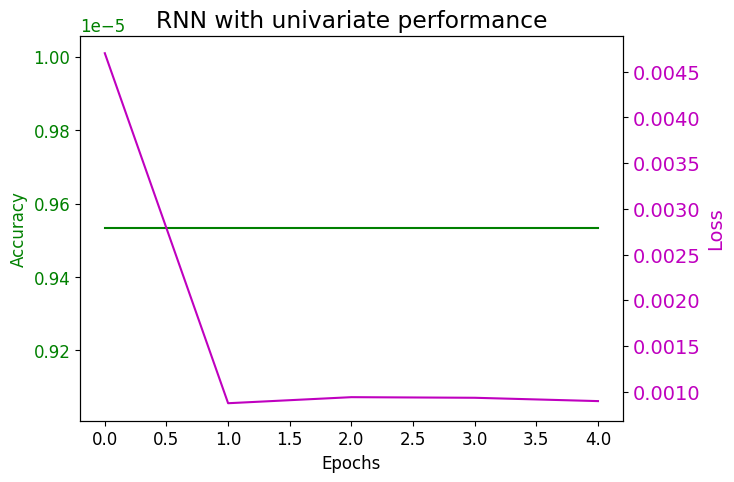

700/700 ━━━━━━━━━━━━━━━━━━━━ 22s 30ms/step


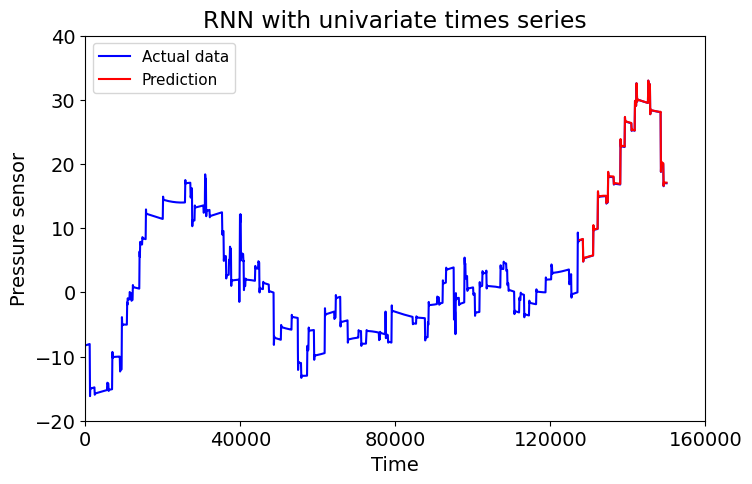

700/700 ━━━━━━━━━━━━━━━━━━━━ 23s 33ms/step - accuracy: 1.0644e-05 - loss: 1.9690e-06
Accuracy: 0.00%
Loss: 0.0000

Total time elapsed: 2103.25s


In [ ]:
#10. RNN with univariate times series
start = time.time()
train_tune_model(epoch_tuning = 5,                            # number of iteration for hyperparameter tuning
                 max_tuning = 10,                              # maximum number of different hyperparameter configurations to try
                 epoch = 40,                                   # number of iteration for training best hyperparameters
                 BatchSize = 32,
                 model = RNN_model,
                 filename = 'RNN_uni',                        # for saving results
                 plotname = 'RNN with univariate',            # for plotting
                 scaler = scalerUni,                          # Normalization
                 df2_raw = df2_uni,                           # for plotting
                 x_train = x_train_uni,
                 y_train = y_train_uni,
                 x_val = x_val_uni,
                 y_val = y_val_uni,
                 x_test = x_test_uni,
                 y_test = y_test_uni
                 )

end = time.time()
print(f"\nTotal time elapsed: {end - start:.2f}s")

Trial 10 Complete [01h 13m 28s]
val_accuracy: 0.0

Best val_accuracy So Far: 0.0
Total elapsed time: 06h 27m 29s


  The optimal hyperparameter 1 is 96.

  The optimal hyperparameter 2 is 0.2.

  


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn_3 (SimpleRNN)        │ (None, 100, 96)        │         9,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_4 (SimpleRNN)        │ (None, 100, 96)        │        18,528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_5 (SimpleRNN)        │ (None, 96)             │        18,528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 96)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 96)             │           384 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            97 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 47,329 (184.88 KB)

 Trainable params: 47,137 (184.13 KB)

 Non-trainable params: 192 (768.00 B)

None
Epoch 1/40
3279/3279 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - accuracy: 8.3432e-06 - loss: 0.1069 - lr: 9.048374180359596e-05
3279/3279 ━━━━━━━━━━━━━━━━━━━━ 327s 98ms/step - accuracy: 8.3436e-06 - loss: 0.1068 - val_accuracy: 0.0000e+00 - val_loss: 3.7115e-04 - learning_rate: 1.0000e-04
Epoch 2/40
3279/3279 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - accuracy: 1.5506e-05 - loss: 0.0020 - lr: 8.187307530779819e-05
3279/3279 ━━━━━━━━━━━━━━━━━━━━ 384s 99ms/step - accuracy: 1.5504e-05 - loss: 0.0020 - val_accuracy: 0.0000e+00 - val_loss: 4.0225e-04 - learning_rate: 9.0484e-05
Epoch 3/40
3279/3279 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - accuracy: 4.4898e-05 - loss: 0.0019 - lr: 7.408182206817179e-05
3279/3279 ━━━━━━━━━━━━━━━━━━━━ 375s 97ms/step - accuracy: 4.4887e-05 - loss: 0.0019 - val_accuracy: 0.0000e+00 - val_loss: 6.5966e-05 - learning_rate: 8.1873e-05
Epoch 4/40
3279/3279 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - accuracy: 1.3966e-05 - loss: 0.0017 - lr: 6.703200460356394e-05
3279/3279 ━━━━━━━━━━━━━━━

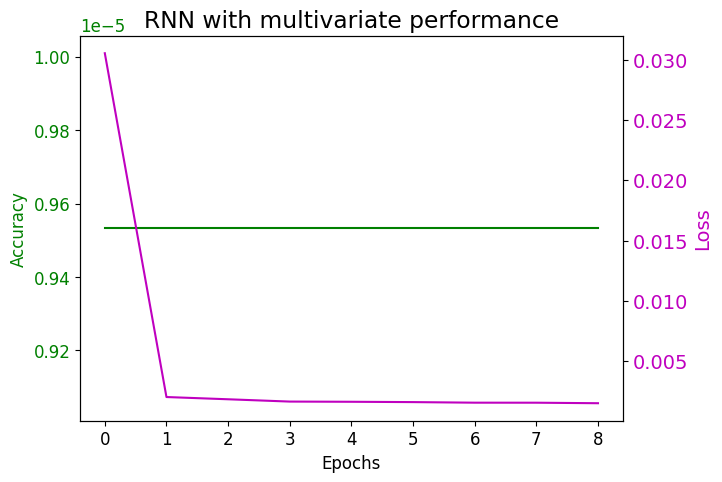

700/700 ━━━━━━━━━━━━━━━━━━━━ 19s 26ms/step


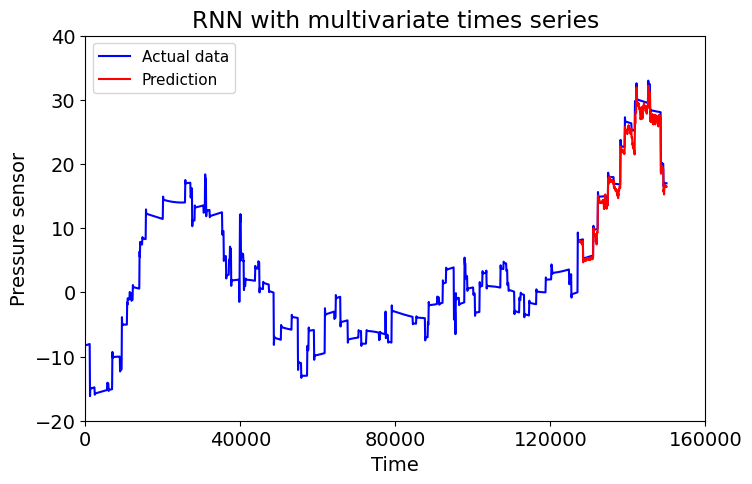

700/700 ━━━━━━━━━━━━━━━━━━━━ 19s 27ms/step - accuracy: 1.0644e-05 - loss: 3.0776e-04
Accuracy: 0.00%
Loss: 0.0005

Total time elapsed: 17923.48s


In [ ]:
#11. RNN with multivariate times series
start = time.time()
train_tune_model(epoch_tuning = 5,                              # number of iteration for hyperparameter tuning
                 max_tuning = 10,                                # maximum number of different hyperparameter configurations to try
                 epoch = 40,                                     # number of iteration for training best hyperparameters
                 BatchSize = 32,
                 model = RNN_model,
                 filename = 'RNN_multi',                        # for saving results
                 plotname = 'RNN with multivariate',            # for plotting
                 scaler = scalerMulti,                          # Normalization
                 df2_raw = df2_uni,                             # for plotting
                 x_train = x_train_multi,
                 y_train = y_train_multi,
                 x_val = x_val_multi,
                 y_val = y_val_multi,
                 x_test = x_test_multi,
                 y_test = y_test_multi
                 )

end = time.time()
print(f"\nTotal time elapsed: {end - start:.2f}s")

Trial 10 Complete [02h 52m 00s]
val_accuracy: 0.0

Best val_accuracy So Far: 0.0
Total elapsed time: 23h 50m 14s


  The optimal hyperparameter 1 is 128.

  The optimal hyperparameter 2 is 0.0.

  


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_3 (LSTM)                   │ (None, 100, 128)       │        66,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ (None, 100, 128)       │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 128)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 330,369 (1.26 MB)

 Trainable params: 330,113 (1.26 MB)

 Non-trainable params: 256 (1.00 KB)

None
Epoch 1/40
3279/3279 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step - accuracy: 3.9952e-06 - loss: 0.0127 - lr: 9.048374180359596e-05
3279/3279 ━━━━━━━━━━━━━━━━━━━━ 1016s 309ms/step - accuracy: 3.9969e-06 - loss: 0.0127 - val_accuracy: 0.0000e+00 - val_loss: 5.9745e-05 - learning_rate: 1.0000e-04
Epoch 2/40
3279/3279 ━━━━━━━━━━━━━━━━━━━━ 0s 285ms/step - accuracy: 1.2098e-05 - loss: 9.6953e-04 - lr: 8.187307530779819e-05
3279/3279 ━━━━━━━━━━━━━━━━━━━━ 1046s 310ms/step - accuracy: 1.2097e-05 - loss: 9.6953e-04 - val_accuracy: 0.0000e+00 - val_loss: 4.4554e-06 - learning_rate: 9.0484e-05
Epoch 3/40
3279/3279 ━━━━━━━━━━━━━━━━━━━━ 0s 285ms/step - accuracy: 2.0330e-05 - loss: 8.8800e-04 - lr: 7.408182206817179e-05
3279/3279 ━━━━━━━━━━━━━━━━━━━━ 1041s 310ms/step - accuracy: 2.0326e-05 - loss: 8.8800e-04 - val_accuracy: 0.0000e+00 - val_loss: 5.3283e-05 - learning_rate: 8.1873e-05
Epoch 4/40
3279/3279 ━━━━━━━━━━━━━━━━━━━━ 0s 285ms/step - accuracy: 1.0303e-05 - loss: 8.7084e-04 - lr: 6.703200460356394

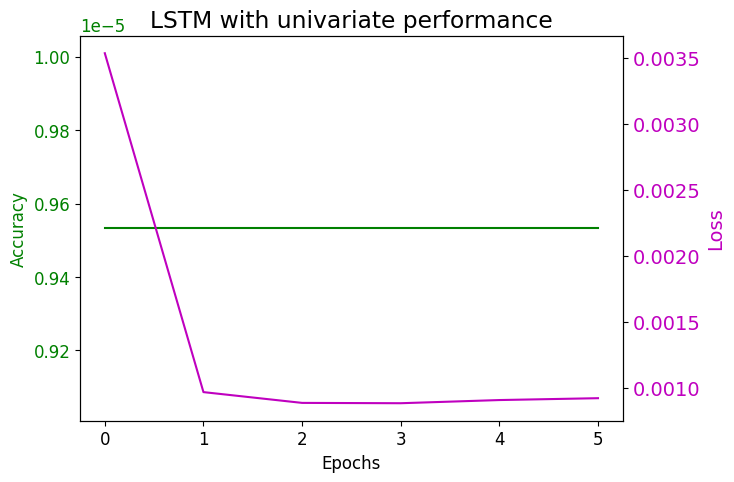

700/700 ━━━━━━━━━━━━━━━━━━━━ 56s 79ms/step


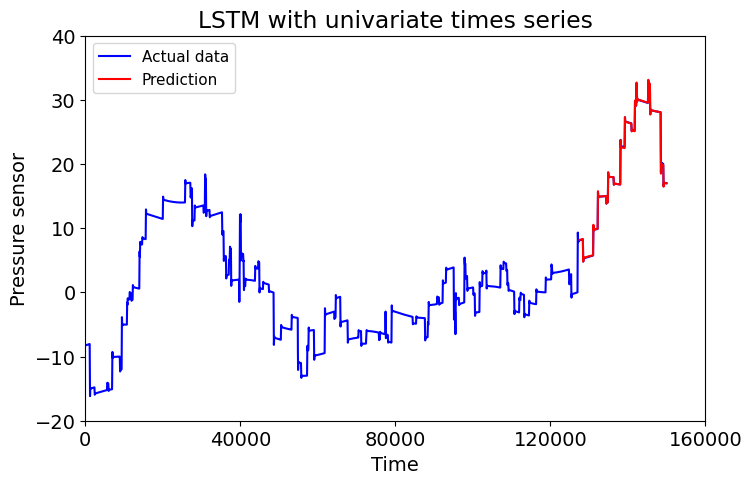

700/700 ━━━━━━━━━━━━━━━━━━━━ 55s 79ms/step - accuracy: 1.0644e-05 - loss: 2.2813e-06
Accuracy: 0.00%
Loss: 0.0000

Total time elapsed: 33657.55s


In [ ]:
#12. LSTM with univariate times series
start = time.time()
train_tune_model(epoch_tuning = 5,                            # number of iteration for hyperparameter tuning
                 max_tuning = 10,                              # maximum number of different hyperparameter configurations to try
                 epoch = 40,                                   # number of iteration for training best hyperparameters
                 BatchSize = 32,
                 model = LSTM_model,
                 filename = 'LSTM_uni',                        # for saving results
                 plotname = 'LSTM with univariate',            # for plotting
                 scaler = scalerUni,                          # Normalization
                 df2_raw = df2_uni,                           # for plotting
                 x_train = x_train_uni,
                 y_train = y_train_uni,
                 x_val = x_val_uni,
                 y_val = y_val_uni,
                 x_test = x_test_uni,
                 y_test = y_test_uni
                 )

end = time.time()
print(f"\nTotal time elapsed: {end - start:.2f}s")

Trial 10 Complete [00h 21m 30s]
val_accuracy: 0.0

Best val_accuracy So Far: 0.0
Total elapsed time: 03h 37m 16s


  The optimal hyperparameter 1 is 64.

  The optimal hyperparameter 2 is 0.4.

  


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_3 (LSTM)                   │ (None, 100, 64)        │        17,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ (None, 100, 64)        │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 84,289 (329.25 KB)

 Trainable params: 84,161 (328.75 KB)

 Non-trainable params: 128 (512.00 B)

None
Epoch 1/40
3279/3279 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 2.5125e-06 - loss: 0.0240 - lr: 9.048374180359596e-05
3279/3279 ━━━━━━━━━━━━━━━━━━━━ 101s 29ms/step - accuracy: 2.5146e-06 - loss: 0.0240 - val_accuracy: 0.0000e+00 - val_loss: 1.9662e-04 - learning_rate: 1.0000e-04
Epoch 2/40
3278/3279 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 3.6633e-06 - loss: 0.0025 - lr: 8.187307530779819e-05
3279/3279 ━━━━━━━━━━━━━━━━━━━━ 89s 27ms/step - accuracy: 3.6669e-06 - loss: 0.0025 - val_accuracy: 0.0000e+00 - val_loss: 2.8187e-04 - learning_rate: 9.0484e-05
Epoch 3/40
3277/3279 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 3.7168e-05 - loss: 0.0024 - lr: 7.408182206817179e-05
3279/3279 ━━━━━━━━━━━━━━━━━━━━ 90s 27ms/step - accuracy: 3.7143e-05 - loss: 0.0024 - val_accuracy: 0.0000e+00 - val_loss: 6.8091e-05 - learning_rate: 8.1873e-05
Epoch 4/40
3278/3279 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 1.1945e-05 - loss: 0.0023 - lr: 6.703200460356394e-05
3279/3279 ━━━━━━━━━━━━━━━━━

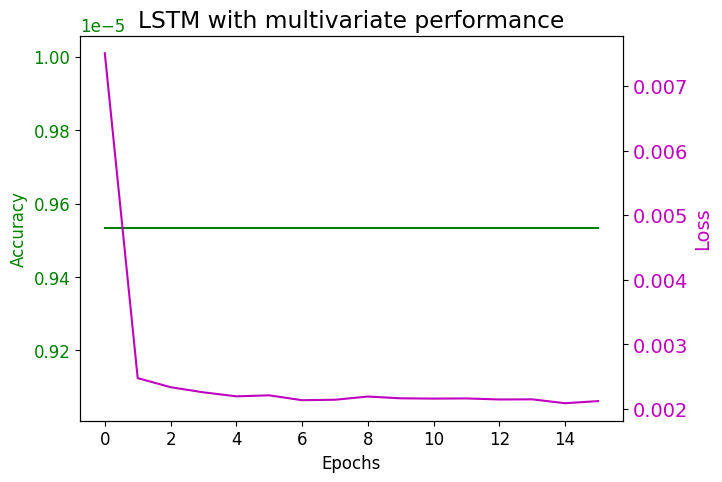

700/700 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step


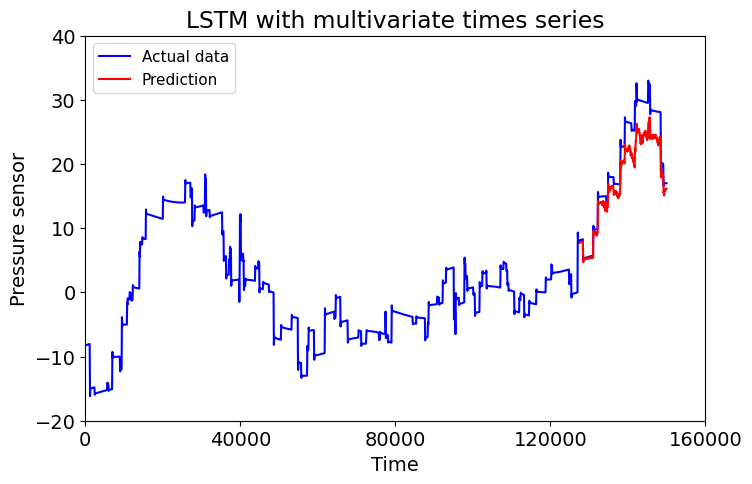

700/700 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 1.0644e-05 - loss: 0.0018
Accuracy: 0.00%
Loss: 0.0045

Total time elapsed: 14930.26s


In [ ]:
#13. LSTM with multivariate times series
start = time.time()
train_tune_model(epoch_tuning = 5,                              # number of iteration for hyperparameter tuning
                 max_tuning = 10,                                # maximum number of different hyperparameter configurations to try
                 epoch = 40,                                     # number of iteration for training best hyperparameters
                 BatchSize = 32,
                 model = LSTM_model,
                 filename = 'LSTM_multi',                        # for saving results
                 plotname = 'LSTM with multivariate',            # for plotting
                 scaler = scalerMulti,                          # Normalization
                 df2_raw = df2_uni,                             # for plotting, df2_uni for both univariate and multivariate
                 x_train = x_train_multi,
                 y_train = y_train_multi,
                 x_val = x_val_multi,
                 y_val = y_val_multi,
                 x_test = x_test_multi,
                 y_test = y_test_multi
                 )

end = time.time()
print(f"\nTotal time elapsed: {end - start:.2f}s")

Reloading Tuner from ./Transformer_uni/tuner0.json
Search space summary
Default search space size: 2
units (Int)
{'default': None, 'conditions': [], 'min_value': 64, 'max_value': 128, 'step': 32, 'sampling': 'linear'}
dropout (Float)
{'default': 0.0, 'conditions': [], 'min_value': 0.0, 'max_value': 0.4, 'step': 0.2, 'sampling': 'linear'}


  The optimal hyperparameter 1 is 128.

  The optimal hyperparameter 2 is 0.0.

  


Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 100, 1)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_50 (Dense)                │ (None, 100, 128)       │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_encoder_1           │ (None, 100, 128)       │       793,088 │
│ (TransformerEncoder)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 12800)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_51 (Dense)                │ (None, 1)              │        12,801 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 806,145 (3.08 MB)

 Trainable params: 806,145 (3.08 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/40
3279/3279 ━━━━━━━━━━━━━━━━━━━━ 0s 680ms/step - accuracy: 6.8361e-07 - loss: 0.1398 - lr: 9.048374180359596e-05
3279/3279 ━━━━━━━━━━━━━━━━━━━━ 2447s 742ms/step - accuracy: 6.8631e-07 - loss: 0.1398 - val_accuracy: 0.0000e+00 - val_loss: 0.0025 - learning_rate: 1.0000e-04
Epoch 2/40
3279/3279 ━━━━━━━━━━━━━━━━━━━━ 0s 671ms/step - accuracy: 1.5640e-05 - loss: 0.0132 - lr: 8.187307530779819e-05
3279/3279 ━━━━━━━━━━━━━━━━━━━━ 2403s 733ms/step - accuracy: 1.5638e-05 - loss: 0.0132 - val_accuracy: 0.0000e+00 - val_loss: 8.3362e-04 - learning_rate: 9.0484e-05
Epoch 3/40
3279/3279 ━━━━━━━━━━━━━━━━━━━━ 0s 672ms/step - accuracy: 1.0329e-05 - loss: 0.0031 - lr: 7.408182206817179e-05
3279/3279 ━━━━━━━━━━━━━━━━━━━━ 2425s 734ms/step - accuracy: 1.0329e-05 - loss: 0.0031 - val_accuracy: 0.0000e+00 - val_loss: 0.0094 - learning_rate: 8.1873e-05
Epoch 4/40
3279/3279 ━━━━━━━━━━━━━━━━━━━━ 0s 670ms/step - accuracy: 7.8208e-06 - loss: 0.0012 - lr: 6.703200460356394e-05
3279/3279 ━━━━━━━━━━━━━

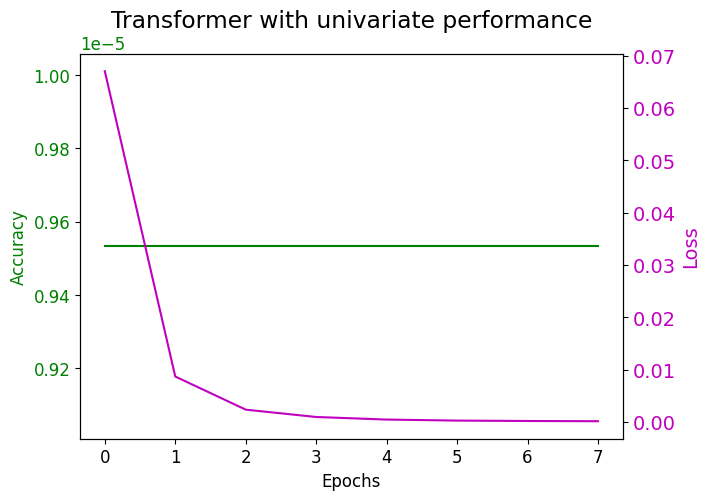

700/700 ━━━━━━━━━━━━━━━━━━━━ 152s 216ms/step


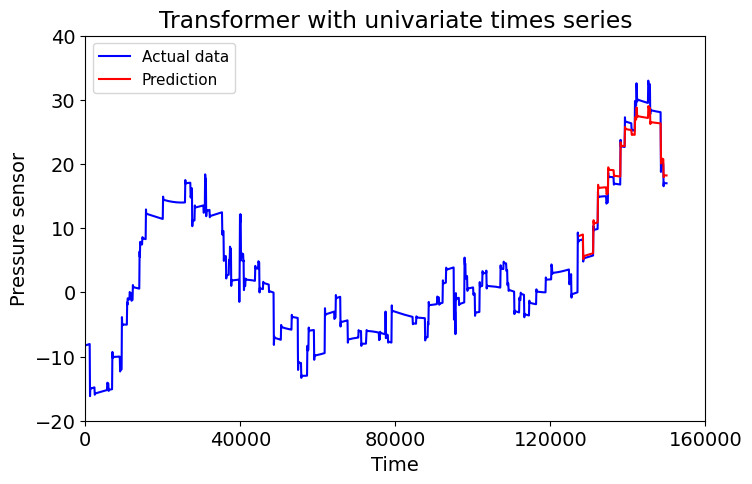

700/700 ━━━━━━━━━━━━━━━━━━━━ 152s 217ms/step - accuracy: 1.0644e-05 - loss: 5.1970e-04
Accuracy: 0.00%
Loss: 0.0010

Total time elapsed: 19724.68s


In [ ]:
#14. Transformer with univariate times series
start = time.time()
train_tune_model(epoch_tuning = 5,                            # number of iteration for hyperparameter tuning
                 max_tuning = 10,                              # maximum number of different hyperparameter configurations to try
                 epoch = 40,                                   # number of iteration for training best hyperparameters
                 BatchSize = 32,
                 model = Transformer_model,
                 filename = 'Transformer_uni',                        # for saving results
                 plotname = 'Transformer with univariate',            # for plotting
                 scaler = scalerUni,                          # Normalization
                 df2_raw = df2_uni,                           # for plotting
                 x_train = x_train_uni,
                 y_train = y_train_uni,
                 x_val = x_val_uni,
                 y_val = y_val_uni,
                 x_test = x_test_uni,
                 y_test = y_test_uni
                 )

end = time.time()
print(f"\nTotal time elapsed: {end - start:.2f}s")

Reloading Tuner from ./Transformer_multi/tuner0.json
Search space summary
Default search space size: 2
units (Int)
{'default': None, 'conditions': [], 'min_value': 64, 'max_value': 128, 'step': 32, 'sampling': 'linear'}
dropout (Float)
{'default': 0.0, 'conditions': [], 'min_value': 0.0, 'max_value': 0.4, 'step': 0.2, 'sampling': 'linear'}


  The optimal hyperparameter 1 is 128.

  The optimal hyperparameter 2 is 0.0.

  


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 100, 5)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 100, 128)       │           768 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_encoder             │ (None, 100, 128)       │       793,088 │
│ (TransformerEncoder)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 12800)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 1)              │        12,801 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 806,657 (3.08 MB)

 Trainable params: 806,657 (3.08 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/40
3279/3279 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 3.0094e-06 - loss: 0.1600 - lr: 9.048374180359596e-05
3279/3279 ━━━━━━━━━━━━━━━━━━━━ 90s 21ms/step - accuracy: 3.0114e-06 - loss: 0.1600 - val_accuracy: 0.0000e+00 - val_loss: 0.0065 - learning_rate: 1.0000e-04
Epoch 2/40
3279/3279 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 1.4835e-05 - loss: 0.0087 - lr: 8.187307530779819e-05
3279/3279 ━━━━━━━━━━━━━━━━━━━━ 62s 18ms/step - accuracy: 1.4833e-05 - loss: 0.0087 - val_accuracy: 0.0000e+00 - val_loss: 4.1683e-04 - learning_rate: 9.0484e-05
Epoch 3/40
3276/3279 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 1.8000e-05 - loss: 0.0017 - lr: 7.408182206817179e-05
3279/3279 ━━━━━━━━━━━━━━━━━━━━ 81s 17ms/step - accuracy: 1.7989e-05 - loss: 0.0017 - val_accuracy: 0.0000e+00 - val_loss: 3.0894e-04 - learning_rate: 8.1873e-05
Epoch 4/40
3279/3279 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 9.3037e-06 - loss: 7.4182e-04 - lr: 6.703200460356394e-05
3279/3279 ━━━━━━━━━━━━━━━━━━

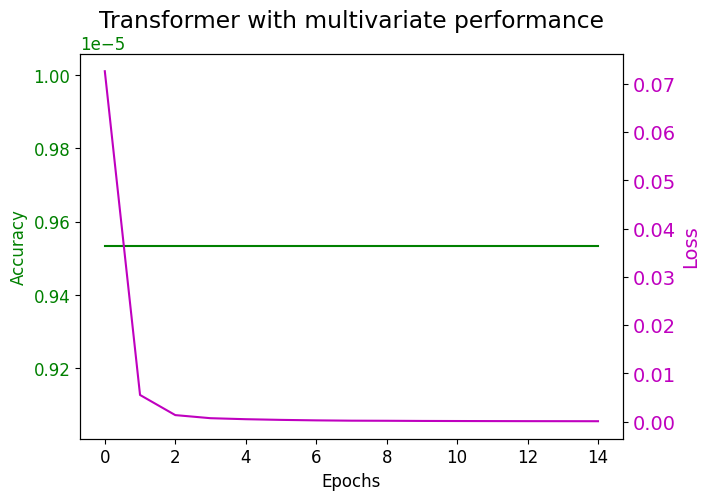

700/700 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step


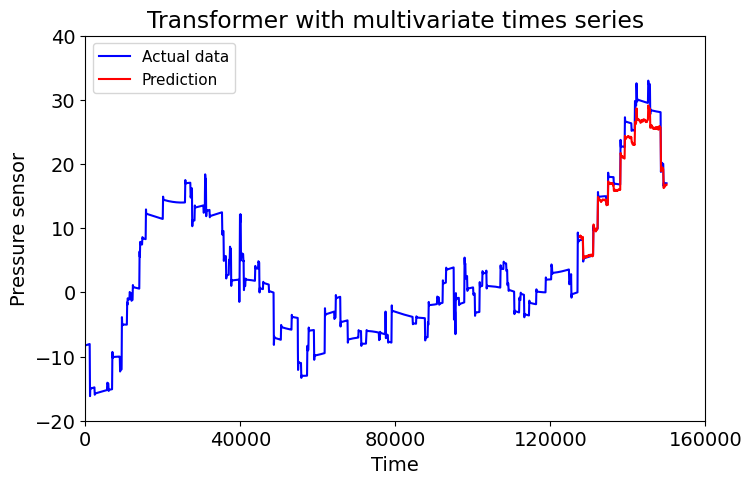

700/700 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 1.0644e-05 - loss: 5.6118e-04
Accuracy: 0.00%
Loss: 0.0014

Total time elapsed: 1240.06s


In [ ]:
#15. Transformer with multivariate times series
start = time.time()
train_tune_model(epoch_tuning = 5,                              # number of iteration for hyperparameter tuning
                 max_tuning = 10,                                # maximum number of different hyperparameter configurations to try
                 epoch = 40,                                     # number of iteration for training best hyperparameters
                 BatchSize = 32,
                 model = Transformer_model,
                 filename = 'Transformer_multi',                        # for saving results
                 plotname = 'Transformer with multivariate',            # for plotting
                 scaler = scalerMulti,                          # Normalization
                 df2_raw = df2_uni,                             # for plotting, df2_uni for both univariate and multivariate
                 x_train = x_train_multi,
                 y_train = y_train_multi,
                 x_val = x_val_multi,
                 y_val = y_val_multi,
                 x_test = x_test_multi,
                 y_test = y_test_multi
                 )

end = time.time()
print(f"\nTotal time elapsed: {end - start:.2f}s")

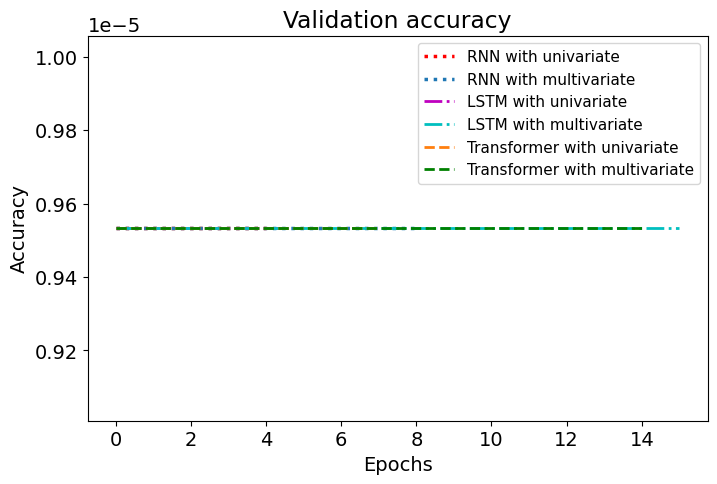

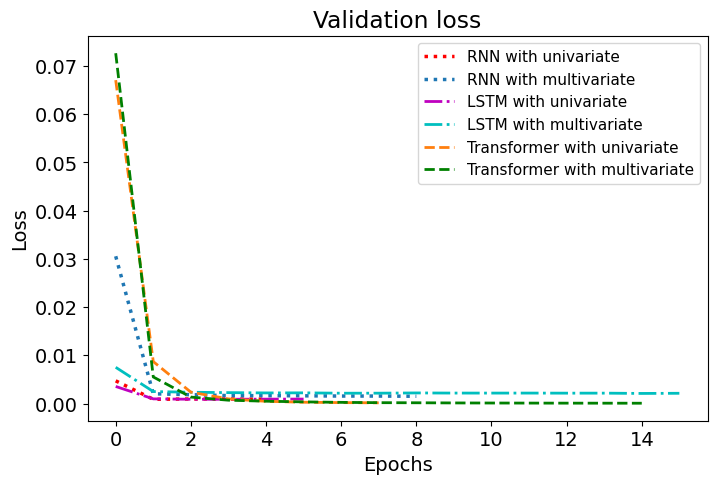

In [ ]:
#16. Visualization of validation performance with accuracy and loss curves
model_list = ['RNN_uni', 'RNN_multi', 'LSTM_uni', 'LSTM_multi', 'Transformer_uni', 'Transformer_multi']
history_ = np.empty(len(model_list), object)
for i in range(len(model_list)):
  if model_list[i] == 'Transformer_uni' or model_list[i] == 'Transformer_multi':
    history_[i] = np.load(model_list[i]+'_history.npy', allow_pickle=True)
  else:
    history_[i] = np.load(model_list[i]+'_history.npy', allow_pickle=True).item()

# Validation accuracy
plt.subplots(figsize=(8, 5))
plt.rcParams['font.size'] = '14'
plt.title('Validation accuracy')
plt.plot(history_[0].history['accuracy'], color='r', linestyle=':', linewidth=2.5, label='RNN with univariate')
plt.plot(history_[1].history['accuracy'], color='tab:blue', linestyle=':', linewidth=2.5, label='RNN with multivariate')
plt.plot(history_[2].history['accuracy'], color='m', linestyle='-.', linewidth=2, label='LSTM with univariate')
plt.plot(history_[3].history['accuracy'], color='c', linestyle='-.', linewidth=2, label='LSTM with multivariate')
plt.plot(history_[4][0], color='tab:orange', linestyle='--', linewidth=2, label='Transformer with univariate')
plt.plot(history_[5][0], color='g', linestyle='--', linewidth=2, label='Transformer with multivariate')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(prop={'size': 11})
plt.grid(False)
plt.show()

# Validation loss
plt.subplots(figsize=(8, 5))
plt.rcParams['font.size'] = '14'
plt.title('Validation loss')
plt.plot(history_[0].history['loss'], color='r', linestyle=':', linewidth=2.5, label='RNN with univariate')
plt.plot(history_[1].history['loss'], color='tab:blue', linestyle=':', linewidth=2.5, label='RNN with multivariate')
plt.plot(history_[2].history['loss'], color='m', linestyle='-.', linewidth=2, label='LSTM with univariate')
plt.plot(history_[3].history['loss'], color='c', linestyle='-.', linewidth=2, label='LSTM with multivariate')
plt.plot(history_[4][1], color='tab:orange', linestyle='--', linewidth=2, label='Transformer with univariate')
plt.plot(history_[5][1], color='g', linestyle='--', linewidth=2, label='Transformer with multivariate')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(prop={'size': 11})
plt.grid(False)
plt.show()

In [ ]:
#17. Model evaluation for all approaches
model_list = ['RNN_uni', 'RNN_multi', 'LSTM_uni', 'LSTM_multi', 'Transformer_uni', 'Transformer_multi']
pred = np.empty(len(model_list), object)
for i in range(len(model_list)):
  pred[i] = np.load(model_list[i]+'_pred_eval.npy', allow_pickle=True)

# Model evaluation: Accuracy and Loss from model_best.evaluate(x_test, y_test)
'''
data = {
    'Model': ['RNN', 'RNN', 'LSTM', 'LSTM', 'Transformer', 'Transformer'],
    'Time series': ['Univariate', 'Multivariate','Univariate', 'Multivariate','Univariate', 'Multivariate'],
    'Accuracy': [f'{pred[0][1]*100:.2f}%', f'{pred[1][1]*100:.2f}%', f'{pred[2][1]*100:.2f}%', f'{pred[3][1]*100:.2f}%', f'{pred[4][1]*100:.2f}%', f'{pred[5][1]*100:.2f}%'],
    'Loss': [f'{pred[0][2]:.4f}%', f'{pred[1][2]:.4f}%', f'{pred[2][2]:.4f}%', f'{pred[3][2]:.4f}%', f'{pred[4][2]:.4f}%', f'{pred[5][2]:.4f}%']
}
ModelEva = pd.DataFrame(data)
print(ModelEva)
'''

# Model evaluation: R-squared and SMAPE (Symmetric Mean Absolute Percentage Error)
from sklearn.metrics import root_mean_squared_error
from sklearn.metrics import mean_absolute_error

def calculate_smape(actual, predicted) -> float:
    # Convert actual and predicted to numpy
    # array data type if not already
    # problem when actual values are close to zero.
    if not all([isinstance(actual, np.ndarray),
                isinstance(predicted, np.ndarray)]):
        actual, predicted = np.array(actual), np.array(predicted)
    return round(
        np.mean(
            np.abs(predicted - actual) /
            ((np.abs(predicted) + np.abs(actual))/2)
        )*100, 2
    )

y_test = df2_uni[(len(df2_uni)-len(pred[0][0])):]
smape = np.empty(len(model_list), object)
mae = np.empty(len(model_list), object)
rmse = np.empty(len(model_list), object)
for i in range(len(model_list)):
  smape[i] = calculate_smape(y_test, pred[i][0])
  mae[i] = mean_absolute_error(y_test, pred[i][0])
  rmse[i] = root_mean_squared_error(y_test, pred[i][0])

data2 = {
    'Model': ['RNN', 'RNN', 'LSTM', 'LSTM', 'Transformer', 'Transformer'],
    'Time series': ['Univariate', 'Multivariate','Univariate', 'Multivariate','Univariate', 'Multivariate'],
    'MAE': [f'{mae[0]:.4f}', f'{mae[1]:.4f}', f'{mae[2]:.4f}', f'{mae[3]:.4f}', f'{mae[4]:.4f}', f'{mae[5]:.4f}'],
    'RMSE': [f'{rmse[0]:.4f}', f'{rmse[1]:.4f}', f'{rmse[2]:.4f}', f'{rmse[3]:.4f}', f'{rmse[4]:.4f}', f'{rmse[5]:.4f}'],
    'SMAPE': [f'{smape[0]:.2f}%', f'{smape[1]:.2f}%', f'{smape[2]:.2f}%', f'{smape[3]:.2f}%', f'{smape[4]:.2f}%', f'{smape[5]:.2f}%']
}
ModelEva2 = pd.DataFrame(data2)
ModelEva2


,Model,Time series,MAE,RMSE,SMAPE
0,RNN,Univariate,0.0632,0.0838,0.42%
1,RNN,Multivariate,0.9401,1.1333,54.61%
2,LSTM,Univariate,0.0566,0.0983,0.40%
3,LSTM,Multivariate,2.6420,3.3004,53.58%
4,Transformer,Univariate,1.3368,1.5562,6.87%
5,Transformer,Multivariate,1.4929,1.8698,52.65%


In [ ]:
def smape(actual, prediction):
    smape = 1/len(actual)*np.sum(2*np.abs(prediction-actual)/(np.abs(actual)
                                                 + np.abs(prediction))*100)
    return smape

a=smape(y_test, pred[0][0])
print(a)

0.42115616924793375


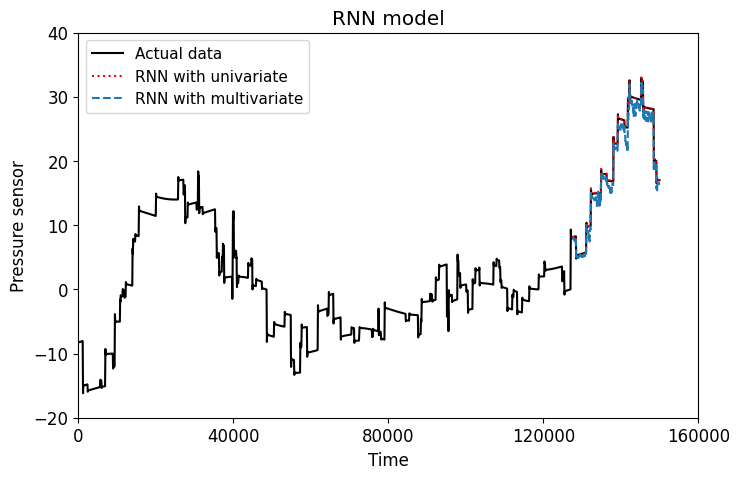

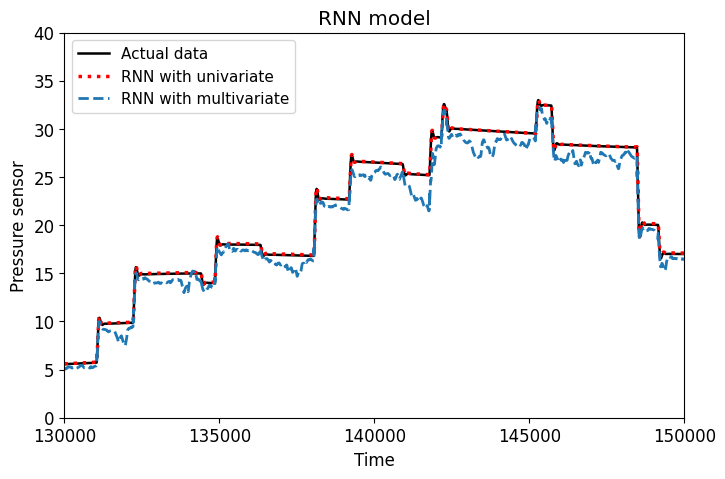

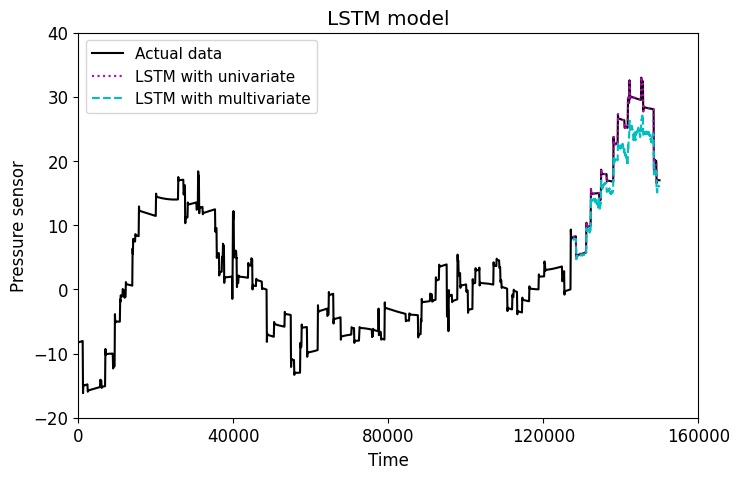

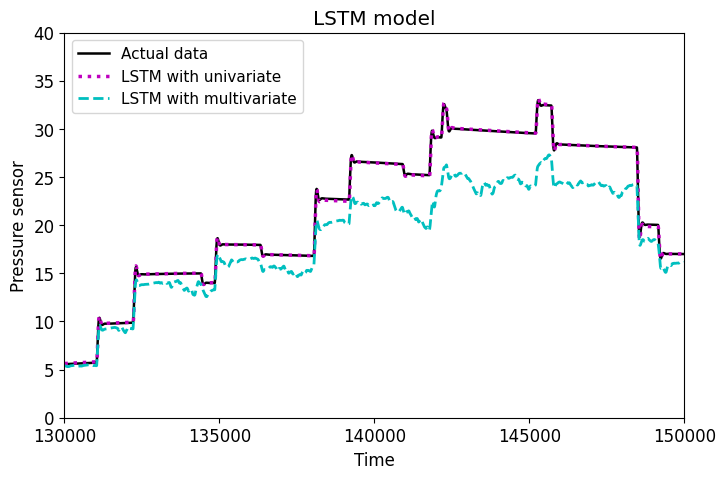

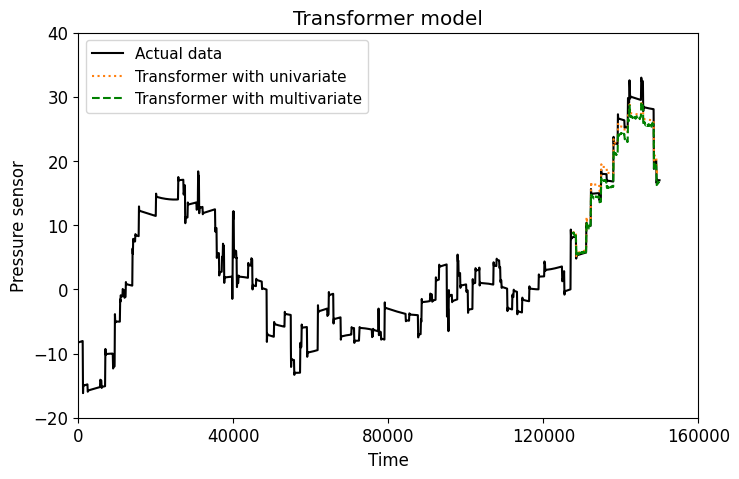

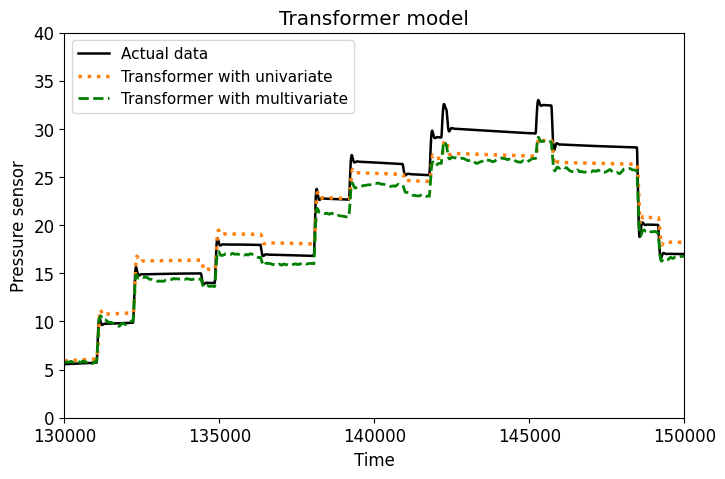

In [ ]:
#18. Visualization of model predictions for all approaches
# RNN ############################################
# Plot prediction
plt.figure(figsize = (8,5))
plt.plot(df2_uni, color = 'k', label='Actual data')
plt.plot(np.arange(len(df2_uni)-len(pred[0][0]), len(df2_uni)), pred[0][0], color = 'r', linestyle=':', label='RNN with univariate')
plt.plot(np.arange(len(df2_uni)-len(pred[1][0]), len(df2_uni)), pred[1][0], color = 'tab:blue', linestyle='--', label='RNN with multivariate')
plt.title('RNN model')
plt.xlabel('Time')
plt.ylabel('Pressure sensor')
plt.xlim(0,160000)
plt.xticks(np.arange(0,200000,40000))
plt.ylim(-20,40)
plt.legend(prop={'size': 11})
plt.show()

# Plot prediction
plt.figure(figsize = (8,5))
plt.plot(df2_uni, color = 'k', linewidth=1.8, label='Actual data')
plt.plot(np.arange(len(df2_uni)-len(pred[0][0]), len(df2_uni)), pred[0][0], color = 'r', linestyle=':', linewidth=2.5, label='RNN with univariate')
plt.plot(np.arange(len(df2_uni)-len(pred[1][0]), len(df2_uni)), pred[1][0], color = 'tab:blue', linestyle='--', linewidth=2, label='RNN with multivariate')
plt.title('RNN model')
plt.xlabel('Time')
plt.ylabel('Pressure sensor')
plt.xlim(130000,150000)
plt.xticks(np.arange(130000,155000,5000))
plt.ylim(0,40)
plt.legend(prop={'size': 11})
plt.show()

# LSTM ############################################
# Plot prediction
plt.figure(figsize = (8,5))
plt.plot(df2_uni, color = 'k', label='Actual data')
plt.plot(np.arange(len(df2_uni)-len(pred[2][0]), len(df2_uni)), pred[2][0], color = 'm', linestyle=':', label='LSTM with univariate')
plt.plot(np.arange(len(df2_uni)-len(pred[3][0]), len(df2_uni)), pred[3][0], color = 'c', linestyle='--', label='LSTM with multivariate')
plt.title('LSTM model')
plt.xlabel('Time')
plt.ylabel('Pressure sensor')
plt.xlim(0,160000)
plt.xticks(np.arange(0,200000,40000))
plt.ylim(-20,40)
plt.legend(prop={'size': 11})
plt.show()

# Plot prediction
plt.figure(figsize = (8,5))
plt.plot(df2_uni, color = 'k', linewidth=1.8, label='Actual data')
plt.plot(np.arange(len(df2_uni)-len(pred[2][0]), len(df2_uni)), pred[2][0], color = 'm', linestyle=':', linewidth=2.5, label='LSTM with univariate')
plt.plot(np.arange(len(df2_uni)-len(pred[3][0]), len(df2_uni)), pred[3][0], color = 'c', linestyle='--', linewidth=2, label='LSTM with multivariate')
plt.title('LSTM model')
plt.xlabel('Time')
plt.ylabel('Pressure sensor')
plt.xlim(130000,150000)
plt.xticks(np.arange(130000,155000,5000))
plt.ylim(0,40)
plt.legend(prop={'size': 11})
plt.show()

# Transformer ############################################
# Plot prediction
plt.figure(figsize = (8,5))
plt.plot(df2_uni, color = 'k', label='Actual data')
plt.plot(np.arange(len(df2_uni)-len(pred[4][0]), len(df2_uni)), pred[4][0], color = 'tab:orange', linestyle=':', label='Transformer with univariate')
plt.plot(np.arange(len(df2_uni)-len(pred[5][0]), len(df2_uni)), pred[5][0], color = 'g', linestyle='--', label='Transformer with multivariate')
plt.title('Transformer model')
plt.xlabel('Time')
plt.ylabel('Pressure sensor')
plt.xlim(0,160000)
plt.xticks(np.arange(0,200000,40000))
plt.ylim(-20,40)
plt.legend(prop={'size': 11})
plt.show()

# Plot prediction
plt.figure(figsize = (8,5))
plt.plot(df2_uni, color = 'k', linewidth=1.8, label='Actual data')
plt.plot(np.arange(len(df2_uni)-len(pred[4][0]), len(df2_uni)), pred[4][0], color = 'tab:orange', linestyle=':', linewidth=2.5, label='Transformer with univariate')
plt.plot(np.arange(len(df2_uni)-len(pred[5][0]), len(df2_uni)), pred[5][0], color = 'g', linestyle='--', linewidth=2, label='Transformer with multivariate')
plt.title('Transformer model')
plt.xlabel('Time')
plt.ylabel('Pressure sensor')
plt.xlim(130000,150000)
plt.xticks(np.arange(130000,155000,5000))
plt.ylim(0,40)
plt.legend(prop={'size': 11})
plt.show()

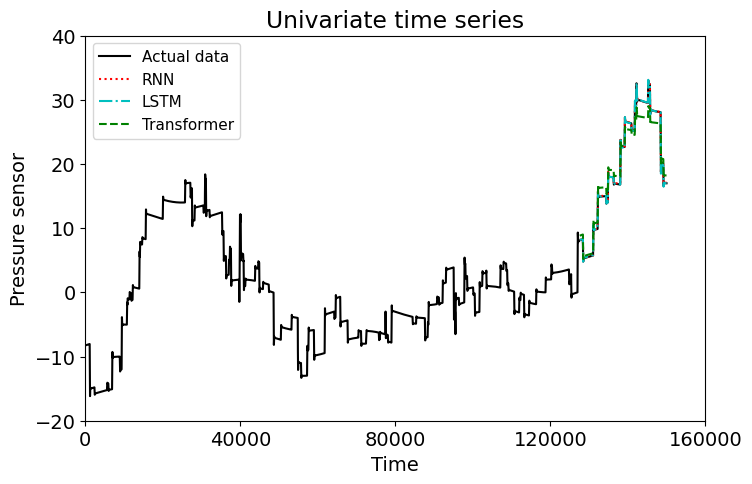

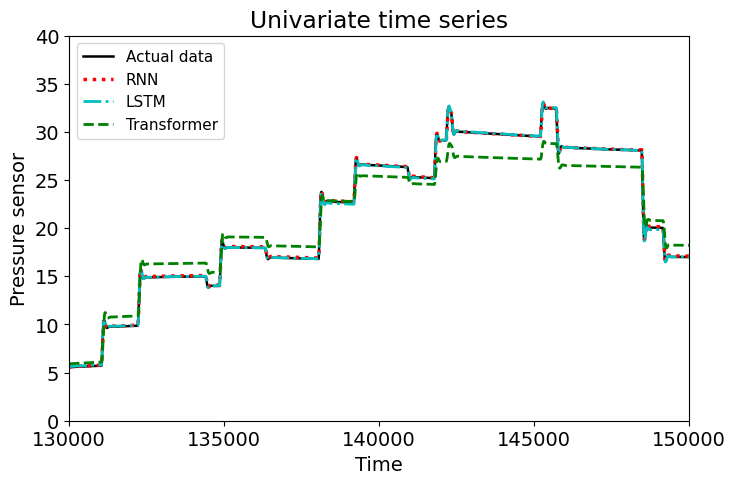

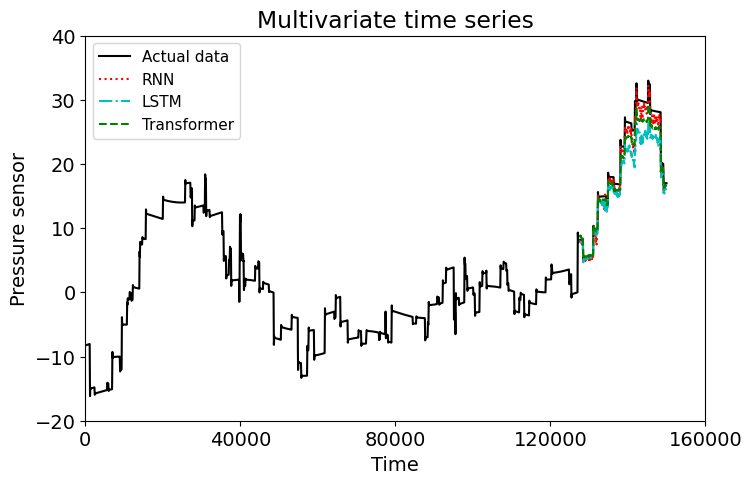

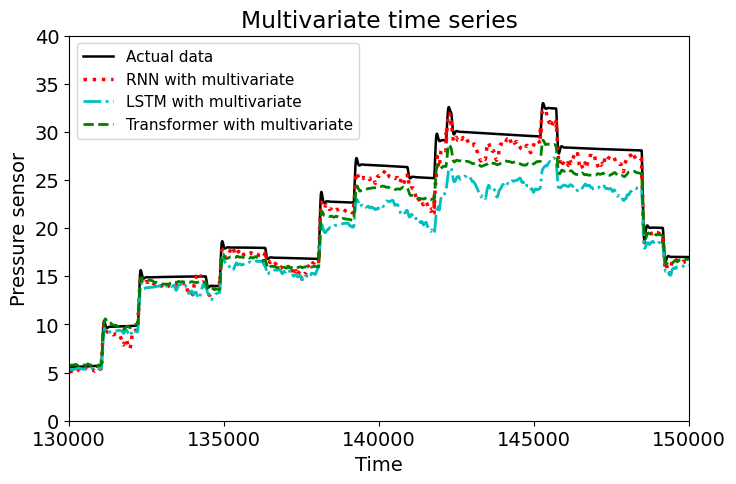

In [ ]:
#18. Visualization of model predictions for all approaches
# Univariate ############################################
# Plot prediction
plt.figure(figsize = (8,5))
plt.plot(df2_uni, color = 'k', label='Actual data')
plt.plot(np.arange(len(df2_uni)-len(pred[0][0]), len(df2_uni)), pred[0][0], color = 'r', linestyle=':', label='RNN')
plt.plot(np.arange(len(df2_uni)-len(pred[2][0]), len(df2_uni)), pred[2][0], color = 'c', linestyle='-.', label='LSTM')
plt.plot(np.arange(len(df2_uni)-len(pred[4][0]), len(df2_uni)), pred[4][0], color = 'g', linestyle='--', label='Transformer')
plt.title('Univariate time series')
plt.xlabel('Time')
plt.ylabel('Pressure sensor')
plt.xlim(0,160000)
plt.xticks(np.arange(0,200000,40000))
plt.ylim(-20,40)
plt.legend(prop={'size': 11})
plt.show()

# Plot prediction
plt.figure(figsize = (8,5))
plt.plot(df2_uni, color = 'k', linewidth=1.8, label='Actual data')
plt.plot(np.arange(len(df2_uni)-len(pred[0][0]), len(df2_uni)), pred[0][0], color = 'r', linestyle=':', linewidth=2.5, label='RNN')
plt.plot(np.arange(len(df2_uni)-len(pred[2][0]), len(df2_uni)), pred[2][0], color = 'c', linestyle='-.', linewidth=2, label='LSTM')
plt.plot(np.arange(len(df2_uni)-len(pred[4][0]), len(df2_uni)), pred[4][0], color = 'g', linestyle='--', linewidth=2, label='Transformer')
plt.title('Univariate time series')
plt.xlabel('Time')
plt.ylabel('Pressure sensor')
plt.xlim(130000,150000)
plt.xticks(np.arange(130000,155000,5000))
plt.ylim(0,40)
plt.legend(prop={'size': 11})
plt.show()

# Multivariate ############################################
# Plot prediction
plt.figure(figsize = (8,5))
plt.plot(df2_uni, color = 'k', label='Actual data')
plt.plot(np.arange(len(df2_uni)-len(pred[1][0]), len(df2_uni)), pred[1][0], color = 'r', linestyle=':', label='RNN')
plt.plot(np.arange(len(df2_uni)-len(pred[3][0]), len(df2_uni)), pred[3][0], color = 'c', linestyle='-.', label='LSTM')
plt.plot(np.arange(len(df2_uni)-len(pred[5][0]), len(df2_uni)), pred[5][0], color = 'g', linestyle='--', label='Transformer')
plt.title('Multivariate time series')
plt.xlabel('Time')
plt.ylabel('Pressure sensor')
plt.xlim(0,160000)
plt.xticks(np.arange(0,200000,40000))
plt.ylim(-20,40)
plt.legend(prop={'size': 11})
plt.show()

# Plot prediction
plt.figure(figsize = (8,5))
plt.plot(df2_uni, color = 'k', linewidth=1.8, label='Actual data')
plt.plot(np.arange(len(df2_uni)-len(pred[1][0]), len(df2_uni)), pred[1][0], color = 'r', linestyle=':', linewidth=2.5, label='RNN with multivariate')
plt.plot(np.arange(len(df2_uni)-len(pred[3][0]), len(df2_uni)), pred[3][0], color = 'c', linestyle='-.', linewidth=2, label='LSTM with multivariate')
plt.plot(np.arange(len(df2_uni)-len(pred[5][0]), len(df2_uni)), pred[5][0], color = 'g', linestyle='--', linewidth=2, label='Transformer with multivariate')
plt.title('Multivariate time series')
plt.xlabel('Time')
plt.ylabel('Pressure sensor')
plt.xlim(130000,150000)
plt.xticks(np.arange(130000,155000,5000))
plt.ylim(0,40)
plt.legend(prop={'size': 11})
plt.show()

In [ ]:
#19. Time series forecasting for all approaches

def make_future_forecast(actual_data, model, into_future, time_step) -> list:
  """
  Makes future forecasts into_future steps after actual data ends.

  Returns future forecasts as list of floats.
  """
  future_forecast = []                           # Make an empty list for future forecasts/prepare data to forecast on
  last_data = actual_data[-time_step:]           # only want predict from the last actual data (this will get updated)

  for _ in range(into_future):                                         # Make INTO_FUTURE number of predictions, altering the data which gets predicted on each time
    last_data_reshaped = last_data.reshape(1, time_step, 1)            # Assuming 1 feature, Reshape last_data to have 3 dimensions (batch_size, timesteps, features)
    future_pred = model.predict(last_data_reshaped)                    # Predict on last data then append it >>> model starts to make forecasts on its own forecasts
    #print(f"Predicting on: \n {last_data} -> Prediction: {tf.squeeze(future_pred).numpy()}\n")
    future_forecast.append(tf.squeeze(future_pred).numpy())            # Append predictions to future_forecast
    last_data = np.append(last_data, future_pred)[-time_step:]         # Update last data with new pred and get time_step most recent preds (model was trained on time_step)
  return future_forecast

model_list = ['RNN_uni', 'LSTM_uni', 'Transformer_uni']
model_list = ['RNN_uni', 'LSTM_uni']
forecast_output = np.empty(len(model_list), object)
for i in range(len(model_list)):
  model_ = keras.saving.load_model(model_list[i]+'.keras')
  future_forecast = make_future_forecast(actual_data = df2_uni_norm,
                                         model = model_,
                                         into_future = 2000,
                                         time_step = 100
                                         )
  forecast_output[i] = scalerUni.inverse_transform(np.reshape(future_forecast, (-1, 1)))

np.save('forecasting.npy', forecast_output)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 526ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━

ValueError: Input contains infinity or a value too large for dtype('float32').

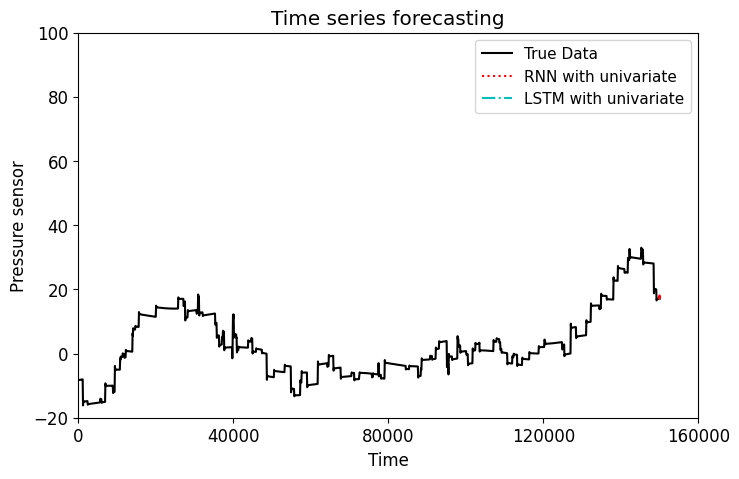

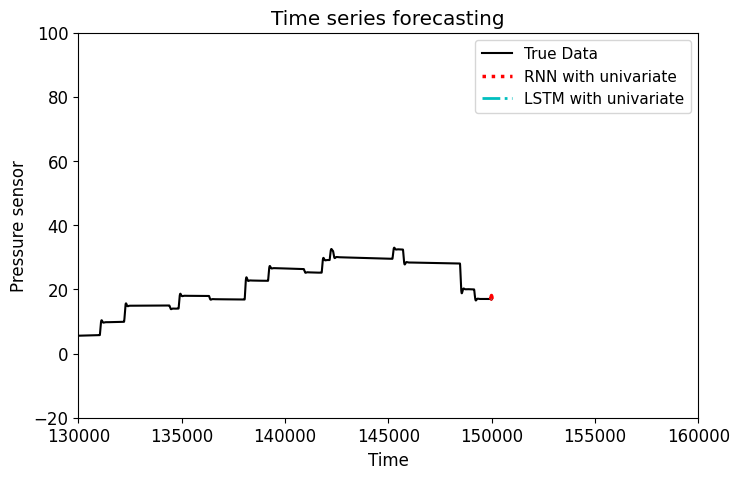

In [ ]:
forecast_output = np.load("forecasting.npy",allow_pickle=True)

# Plot forecasting
plt.figure(figsize = (8,5))
plt.plot(df2_uni, color = 'k', label='True Data')
plt.plot(np.arange(len(df2_uni)-len(forecast_output[0]), len(df2_uni)), forecast_output[0], color = 'r', linestyle=':', label='RNN with univariate')
plt.plot(np.arange(len(df2_uni)-len(forecast_output[1]), len(df2_uni)), forecast_output[1], color = 'c', linestyle='-.', label='LSTM with univariate')
#plt.plot(np.arange(len(df2_uni)-len(forecast_output[2]), len(df2_uni)), forecast_output[2], color = 'g', linestyle='--', label='Transformer with univariate')
plt.title('Time series forecasting')
plt.xlabel('Time')
plt.ylabel('Pressure sensor')
plt.xlim(0,160000)
plt.xticks(np.arange(0,200000,40000))
plt.ylim(-20,100)
plt.legend(prop={'size': 11})
plt.show()

# Plot forecasting
plt.figure(figsize = (8,5))
plt.plot(df2_uni, color = 'k', label='True Data')
plt.plot(np.arange(len(df2_uni)-len(forecast_output[0]), len(df2_uni)), forecast_output[0], color = 'r', linestyle=':', linewidth=2.5, label='RNN with univariate')
plt.plot(np.arange(len(df2_uni)-len(forecast_output[1]), len(df2_uni)), forecast_output[1], color = 'c', linestyle='-.', linewidth=2, label='LSTM with univariate')
#plt.plot(np.arange(len(df2_uni)-len(forecast_output[2]), len(df2_uni)), forecast_output[2], color = 'g', linestyle='--', linewidth=2, label='Transformer with univariate')
plt.title('Time series forecasting')
plt.xlabel('Time')
plt.ylabel('Pressure sensor')
plt.xlim(130000,160000)
plt.xticks(np.arange(130000,165000,5000))
plt.ylim(-20,100)
plt.legend(prop={'size': 11})
plt.show()

In [ ]:
# Hyperparameters tuning with Grid search CV
'''
def build_model(optimizer):
    grid_model = Sequential()
    grid_model.add(LSTM(50,return_sequences=True,input_shape=(30,5)))
    grid_model.add(LSTM(50))
    grid_model.add(Dropout(0.2))
    grid_model.add(Dense(1))
grid_model.compile(loss = 'mse',optimizer = optimizer)
    return grid_model
grid_model = KerasRegressor(build_fn=build_model,verbose=1,validation_data=(testX,testY))
parameters = {'batch_size' : [16,20],
              'epochs' : [8,10],
              'optimizer' : ['adam','Adadelta'] }
grid_search  = GridSearchCV(estimator = grid_model,
                            param_grid = parameters,
                            cv = 2)
grid_search = grid_search.fit(trainX,trainY)
print(grid_search.best_params_)     # best hyperparameters
my_model=grid_search.best_estimator_.model
'''

In [ ]:
#Storytelling
'''
1. Context and Problem Statement
    - Problem
    - Background
    - Goal
2. Data and Methodology
    - Data source
    - Preprocessing step
    - Model: strength, why choose
    - Process
3. Results and Insights
    - Visualization
    - Insights
    - Explain the significant: How do these insights contribute to solving the problem or achieving the goal?
4. Actionable Recommendations and Conclusion
    - Solutions: what actions should be taken?
    - Outlook
    - Summarize the impact
5. Related topics
'''